In [10]:
import dataclasses

import numpy

from matplotlib import pyplot
from scipy import optimize
from scipy import stats

## 8.1, Least squares

> The folder `ElectionsEconomy` contains the data for the example in Section
> 7.1.  Load these data, type in the R function `rss()` from page 104, and
> evaluate it at several different values of $(a, b)$. Make two graphs: a plot
> of the sum of squares of residuals as a function of $a$, with $b$ fixed at its
> least squares estimate given in Section 7.1, and a plot of the sum of squares
> of residuals as a function of $b$, with $a$ fixed at its least squares
> estimate. Confirm that the residual sum of squares is indeed minimized at the
> least squares estimate.

3.0605280543869307
46.247648016800795


(40.0, 52.0)

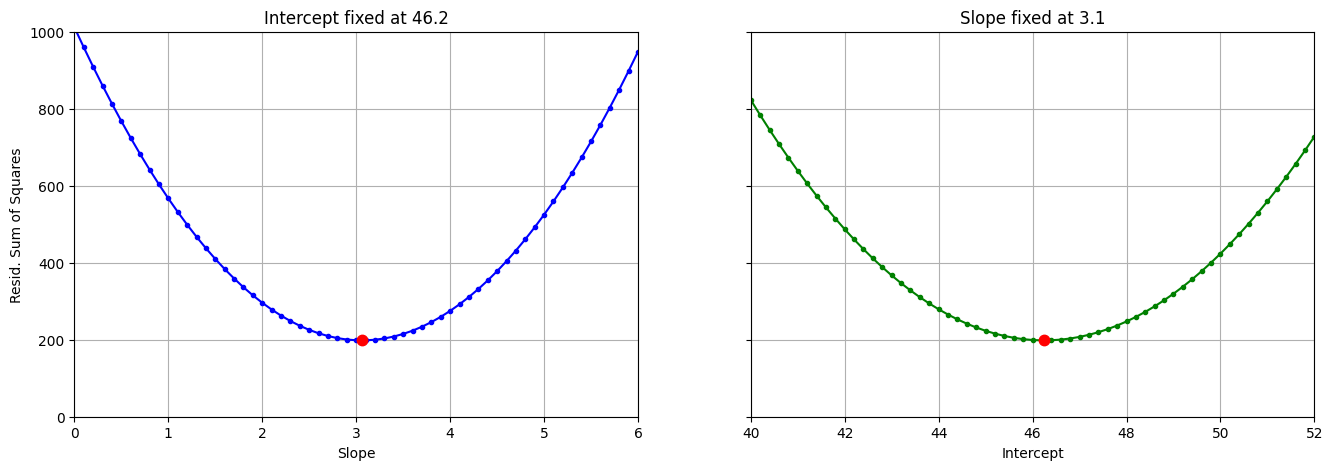

In [11]:
hibbs_dat = '''year growth vote inc_party_candidate other_candidate
1952 2.4 44.6 "Stevenson" "Eisenhower"
1956 2.89 57.76 "Eisenhower" "Stevenson"
1960 .85 49.91 "Nixon" "Kennedy"
1964 4.21 61.34 "Johnson" "Goldwater"
1968 3.02 49.60 "Humphrey" "Nixon"
1972 3.62 61.79 "Nixon" "McGovern"
1976 1.08 48.95 "Ford" "Carter"
1980 -.39 44.70 "Carter" "Reagan"
1984 3.86 59.17 "Reagan" "Mondale"
1988 2.27 53.94 "Bush, Sr." "Dukakis"
1992 .38 46.55 "Bush, Sr." "Clinton"
1996 1.04 54.74 "Clinton" "Dole"
2000 2.36 50.27 "Gore" "Bush, Jr."
2004 1.72 51.24 "Bush, Jr." "Kerry"
2008 .1 46.32 "McCain" "Obama"
2012 .95 52.00 "Obama" "Romney"'''

xs = []
ys = []
for line in hibbs_dat.split('\n')[1:]:
    spline = line.split()
    xs.append(float(spline[1]))
    ys.append(float(spline[2]))
model = stats.linregress(xs, ys)
print(model.slope)
print(model.intercept)

rs = [yi - (model.intercept + model.slope * xi) for (xi, yi) in zip(xs, ys)]

def rss(a: float, b: float) -> float:
    rs = [yi - (a + b * xi) for (xi, yi) in zip(xs, ys)]
    return sum(ri * ri for ri in rs)

bs = numpy.arange(0, 6.05, 0.1)
rss_b = [rss(model.intercept, bi) for bi in bs]

as_ = numpy.arange(40, 52.1, 0.2)
rss_a = [rss(ai, model.slope) for ai in as_]

fig, axs = pyplot.subplots(nrows=1, ncols=2, sharey=True, figsize=(16,5))
axs[0].plot(bs, rss_b, 'b.-')
axs[0].plot([model.slope,], [rss(model.intercept, model.slope),], 'r.', markersize=15)
axs[0].grid()
axs[0].set_ylabel('Resid. Sum of Squares')
axs[0].set_xlabel('Slope')
axs[0].set_title(f'Intercept fixed at {model.intercept:0.1f}')
axs[0].set_ylim(0, 1000)
axs[0].set_xlim(0, 6)
axs[1].plot(as_, rss_a, 'g.-')
axs[1].plot([model.intercept,], [rss(model.intercept, model.slope),], 'r.', markersize=15)
axs[1].grid()
axs[1].set_xlabel('Intercept')
axs[1].set_title(f'Slope fixed at {model.slope:0.1f}')
axs[1].set_xlim(40, 52)

## 8.2, Maximum likelihood

> Repeat the previous exercise but this time write a function, similar to
> `rss()` on page 104, that computes the logarithm of the likelihood (8.6) as a
> function of the data and the parameters $a, b, \sigma$. Evaluate this function
> as several values of these parameters, and make a plot demonstrating that it
> is maximized at the values computed from the formulas in the text (with
> $\sigma$ computed using $\frac{1}{n}$, not $\frac{1}{n-2}$ see page 104).

3.52


(1.5, 5.5)

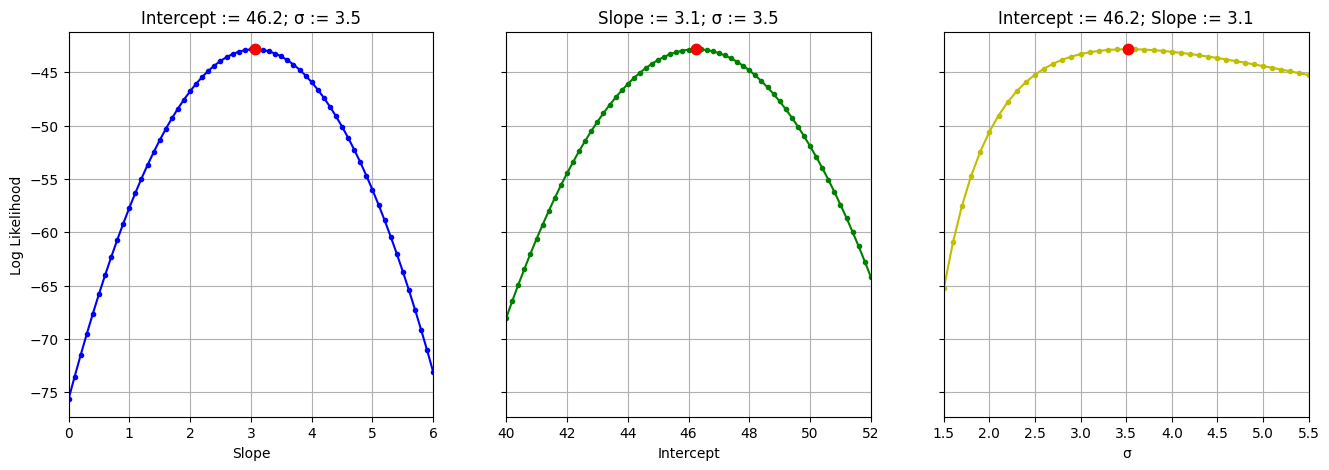

In [12]:
n = len(xs)
sigma = numpy.sqrt(rss(a=model.intercept, b=model.slope)/n)
print(f'{sigma:0.2f}')

def log_likelihood(a: float, b: float, s: float) -> float:
    return -1 * n * numpy.log(numpy.sqrt(2 * 3.141592654) * s) - rss(a=a, b=b)/(2 * s * s)

logpr_b = [log_likelihood(a=model.intercept, b=bi, s=sigma) for bi in bs]
logpr_a = [log_likelihood(a=ai, b=model.slope, s=sigma) for ai in as_]
ss = numpy.arange(1.5, 5.55, 0.1)
logpr_s = [log_likelihood(a=model.intercept, b=model.slope, s=si) for si in ss]

ll_star = log_likelihood(model.intercept, model.slope, sigma)

fig, axs = pyplot.subplots(nrows=1, ncols=3, sharey=True, figsize=(16,5))

axs[0].plot(bs, logpr_b, 'b.-')
axs[0].plot([model.slope,], [ll_star,], 'r.', markersize=15)
axs[0].grid()
axs[0].set_ylabel('Log Likelihood')
axs[0].set_xlabel('Slope')
axs[0].set_title(f'Intercept := {model.intercept:0.1f}; σ := {sigma:0.1f}')
axs[0].set_xlim(0, 6)

axs[1].plot(as_, logpr_a, 'g.-')
axs[1].plot([model.intercept,], [ll_star,], 'r.', markersize=15)
axs[1].grid()
axs[1].set_xlabel('Intercept')
axs[1].set_title(f'Slope := {model.slope:0.1f}; σ := {sigma:0.1f}')
axs[1].set_xlim(40, 52)

axs[2].plot(ss, logpr_s, 'y.-')
axs[2].plot([sigma,], [ll_star,], 'r.', markersize=15)
axs[2].grid()
axs[2].set_xlabel('σ')
axs[2].set_title(f'Intercept := {model.intercept:0.1f}; Slope := {model.slope:0.1f}')
axs[2].set_xlim(1.5, 5.5)

## 8.3, Least absolute deviation

> Repeat 8.1, but instead of calculating and minimizing the sum of squares of
> residuals, do this for the sum of absolute values of residuals. Find the
> $(a, b)$ that minimizes the sum of absolute values of residuals, and plot the
> sum of absolute values of residuals as a function of $a$ and of $b$.
> Compare the least squares and least absolute deviation estimates of $(a, b)$.

In [15]:
@dataclasses.dataclass(frozen=True)
class LeastAbsoluteDeviationModel:
    """Result of fitting a least absolute deviation model."""
    intercept: float
    slope: float

    def predict(self, x: float) -> float:
        return self.intercept + self.slope * x


def least_abs(xs: list[float], ys: list[float]) -> LeastAbsoluteDeviationModel:
    """Fit a least absolute deviation slope-intercept model to the given data."""
    n = len(xs)
    if len(ys) != n:
        raise ValueError(f'Length of xs ({n}) does not match length of ys ({len(ys)}).')
    a_ub = numpy.zeros(shape=(2 * n, n + 2))
    b_ub = numpy.zeros(shape=(2 * n))
    for row_id, (xi, yi) in enumerate(zip(xs, ys)):
        # The first n rows encode `-a - bx_i - t_i <= -y_i`
        a_ub[row_id, 0] = -1
        a_ub[row_id, 1] = -1 * xi
        a_ub[row_id, row_id + 2] = -1
        b_ub[row_id] = -1 * yi
        # The second n rows encode `a + bx_i - t_i <= y_i`
        a_ub[row_id + n, 0] = 1
        a_ub[row_id + n, 1] = xi
        a_ub[row_id + n, row_id + 2] = -1
        b_ub[row_id + n] = yi
    # No constraints on the intercept and slope variables, `a` and `b`:
    bounds = [(None, None), (None, None)]
    # The intercept and slope don't affect the objective:
    c = [0, 0]
    for _ in range(n):
        # The objective just sums the `t`s:
        c.append(1)
        # Let's provide a hint to the solver: the `t`s are non-negative:
        bounds.append((0, None))
    res = optimize.linprog(c=c, A_ub=a_ub, b_ub=b_ub, bounds=bounds)
    if not res.success:
        raise ValueError(f'Linear program failed to converge. Status code: {res.status}; "{res.message}"')
    return LeastAbsoluteDeviationModel(intercept=res.x[0], slope=res.x[1])        

LeastAbsoluteDeviationModel(intercept=np.float64(45.968847926267266), slope=np.float64(3.51152073732719))

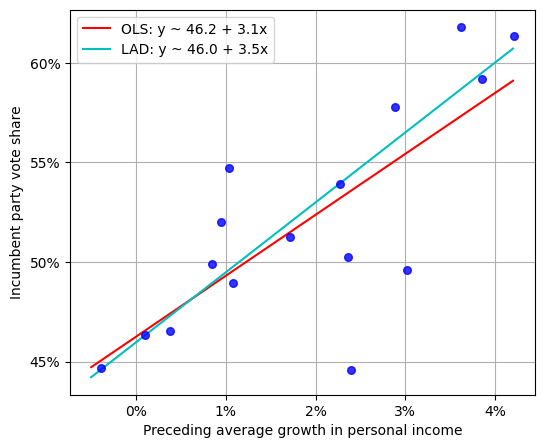

In [19]:
hibbs_lad = least_abs(xs, ys)
hibbs_ols = stats.linregress(xs, ys)

fig = pyplot.figure(figsize=(6, 5))
ax = fig.gca()
ax.plot(
    [-0.5, 4.2], 
    [
        hibbs_ols.intercept - 0.5 * hibbs_ols.slope,
        hibbs_ols.intercept + 4.2 * hibbs_ols.slope,
    ],
    'r-',
    label=f'OLS: y ~ {hibbs_ols.intercept:0.1f} + {hibbs_ols.slope:0.1f}x',
)
ax.plot(
    [-0.5, 4.2], 
    [
        hibbs_lad.intercept - 0.5 * hibbs_lad.slope,
        hibbs_lad.intercept + 4.2 * hibbs_lad.slope,
    ],
    'c-',
    label=f'LAD: y ~ {hibbs_lad.intercept:0.1f} + {hibbs_lad.slope:0.1f}x',
)
ax.plot(xs, ys, 'b.', markersize=11, alpha=0.8)
ax.grid()
xticks = [0, 1, 2, 3, 4]
ax.set_xticks(xticks)
ax.set_xticklabels([f'{xi}%' for xi in xticks])
yticks = [45, 50, 55, 60]
ax.set_yticks(yticks)
ax.set_yticklabels([f'{yi}%' for yi in yticks])
ax.set_ylabel('Incumbent party vote share')
ax.set_xlabel('Preceding average growth in personal income')
ax.legend()

(40.0, 52.0)

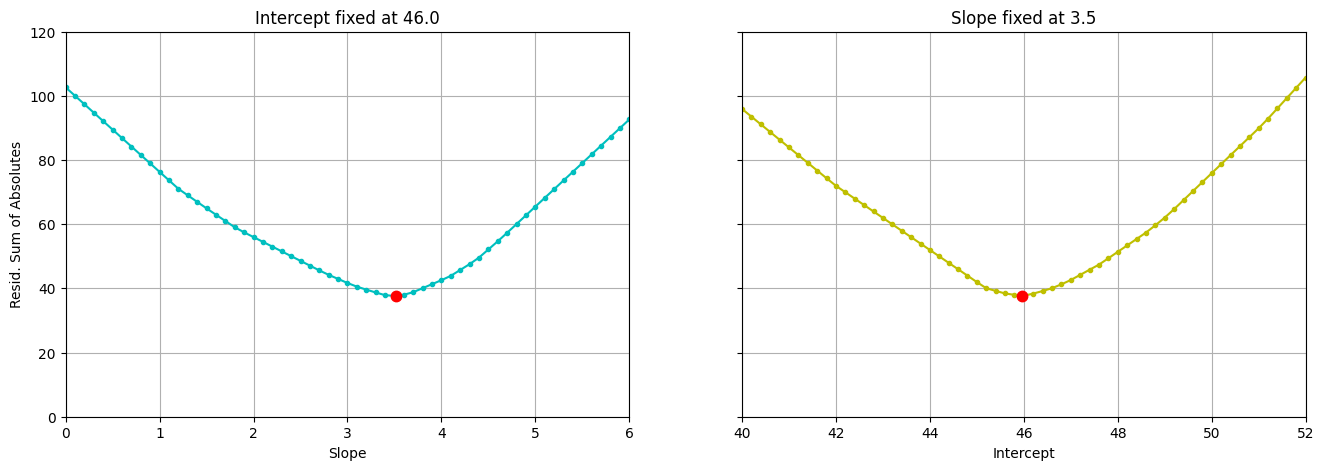

In [23]:
def rsa(a: float, b: float) -> float:
    """Residual sum of absolute (error)."""
    return sum(abs(yi - (a + b * xi)) for (xi, yi) in zip(xs, ys))

bs = numpy.arange(0, 6.05, 0.1)
rsa_b = [rsa(hibbs_lad.intercept, bi) for bi in bs]

as_ = numpy.arange(40, 52.1, 0.2)
rsa_a = [rsa(ai, hibbs_lad.slope) for ai in as_]


fig, axs = pyplot.subplots(nrows=1, ncols=2, sharey=True, figsize=(16,5))
axs[0].plot(bs, rsa_b, 'c.-')
axs[0].plot([hibbs_lad.slope,], [rsa(hibbs_lad.intercept, hibbs_lad.slope),], 'r.', markersize=15)
axs[0].grid()
axs[0].set_ylabel('Resid. Sum of Absolutes')
axs[0].set_xlabel('Slope')
axs[0].set_title(f'Intercept fixed at {hibbs_lad.intercept:0.1f}')
axs[0].set_ylim(0, 120)
axs[0].set_xlim(0, 6)
axs[1].plot(as_, rsa_a, 'y.-')
axs[1].plot([hibbs_lad.intercept,], [rsa(hibbs_lad.intercept, hibbs_lad.slope),], 'r.', markersize=15)
axs[1].grid()
axs[1].set_xlabel('Intercept')
axs[1].set_title(f'Slope fixed at {hibbs_lad.slope:0.1f}')
axs[1].set_xlim(40, 52)

## 8.4, Least squares and least absolute deviation

> Construct a set of data $(x, y)_i$, $i = 1, \ldots, n$, for which the least
> squares and least absolute deviation (see Exercise 8.3) estimates of $(a, b)$
> in the fit, $y = a + bx$, are much different. What did you have to do to make
> this happen?

## 8.6, Influence of individual data points

> (a) Using expression (8.3), compute the influence of each of the data points
>     in the election forecasting example on the fitted slope of the model. Make
>     a graph plotting influence of point $i$ vs. $x_i$.
>
> (b) Re-fit the model $n$ times, for each data point $i$ adding 1 to $y_i$.
>     Save $\hat{b}$ from each of these altered regressions, compare to the
>     $\hat{b}$ from the original data, and check that the influence is
>     approximately the same as computed above using the formula. (The two
>     calculations will not give identical results because `stan_glm` uses a
>     prior distribution and so it does not exactly yield the least squares
>     estimate.)

### 8.6a

In [ ]:
xs = []
ys = []
for line in hibbs_dat.split('\n')[1:]:
    spline = line.split()
    xs.append(float(spline[1]))
    ys.append(float(spline[2]))
xbar = numpy.mean(xs)
ybar = numpy.mean(ys)
print(max(yi - ybar for yi in ys))
denom = sum((xi - xbar) ** 2 for xi in xs)
influence = [abs((xi - xbar) / denom) for (xi, yi) in zip(xs, ys)]

fig = pyplot.figure(figsize=(6, 5))
ax = fig.gca()
ax.plot(xs, influence, 'bo', alpha=0.9)
ax.plot(
    [-0.5, xbar, 4.4], [abs(-0.5 - xbar) / denom, 0, abs(4.4 - xbar) / denom],
    'b--',
    alpha=0.6,
)
xticks = [0, 1, 2, 3, 4]
ax.set_xticks(xticks)
ax.set_xticklabels([f'{xi}%' for xi in xticks])
ax.set_xlabel('Average recent personal income growth')
yticks = [0, 0.02, 0.04, 0.06, 0.08]
ax.set_yticks(yticks)
ax.set_ylabel('Influence')
ax.grid()
ax.set_ylim(0, 0.09)

### 8.6b

In [ ]:
new_slopes = []
for i in range(len(ys)):
    new_ys = list(ys)
    new_ys[i] += 1
    new_model = stats.linregress(xs, new_ys)
    new_slopes.append(new_model.slope)

fig = pyplot.figure(figsize=(6, 5))
ax = fig.gca()
ax.plot(xs, new_slopes, 'go', alpha=0.9)
ax.grid()
ax.axhline(y=model.slope, color='k', linestyle='--')
xticks = [0, 1, 2, 3, 4]
ax.set_xticks(xticks)
ax.set_xticklabels([f'{xi}%' for xi in xticks])
ax.set_xlabel('Average recent personal income growth')
yticks = (2.98, 3.02, 3.06, 3.1, 3.14)
ax.set_yticks(yticks)
ax.set_ylim(2.97, 3.15)
ax.set_ylabel('New slope')
ax.set_title('Effect on slope of adding 1 to y_i')

## 8.7, Least squares slope as a weighted average of individual slopes

> (a) Prove that the weighted average slope defined in equation (8.8) is
>     equivalent to the least squares regression slope in equation (8.3).
>
> (b) Demonstrate how this works in a simple case with three data points,
>     $(x, y) = (0, 0), (4, 1), (5, 5)$.

In [ ]:
print(2 * (16 + 25 + 1))

## 8.8, Comparing `lm` and `stan_glm`

> Use simulated data to compare least squares estimation to default Bayesian
> regression:
>
> (a) Simulate 100 data points from the model, $y = 2 + 3x + \text{error}$, with
>     predictors $x$ drawn from a uniform distribution from 0 to 20, and with
>     independent errors drawn from the normal distribution with mean 0 and
>     standard deviation 5. Fit the regression of $y$ on $x$ data using `lm`
>     and `stan_glm` (using its default settings) and check that the two
>     programs give nearly identical results.
>
> (b) Plot the simulated data and the two fitted regression lines.
>
> (c) Repeat the two steps above, but try to create conditions for your
>     simulation so that `lm` and `stan_glm` give much different results.

## 8.9, Leave-one-out cross validation

> As discussed in the context of (8.5), the root mean square of residuals,
> $\sqrt{\frac{1}{n}\sum_{i=1}^n(y_i - (\hat{a} + \hat{b}x_i))^2}$, is an
> underestimate of the error standard deviation $\sigma$ of the regression
> model, because of overfitting, that the parameters $a$ and $b$ are estimated
> from the same $n$ data points as are being used to compute the residuals.
> Cross validation, which we discuss in detail in Section 11.8, is an
> alternative approach to assessing predictive error that avoids some of the
> problems of overfitting. The simplest version of cross validation is the
> leave-one-out approach, in which the model is fit n times, in each case
> excluding one data point, fitting the model to the remaining $n - 1$ data
> points, and using this fitted model to predict the held-out observation:
> 
> * For $i = 1, \dots, n$:
>    * Fit the model $y = a + bx + \text{error}$ to the $n - 1$ data points
>      $(x, y)_j, j \ne i$. Label the estimated regression coefficients as 
>      $\hat{a}_{-i}$, $\hat{b}_{-i}$.
>    * Compute the cross-validated residual,
>      $r_i^{\text{CV}} = y_i - (\hat{a}_{-i} + \hat{b}_{-i}x_i)$.
> * Compute the estimate
>    $\hat{\sigma}^{\text{CV}} = \sqrt{\frac{1}{n}\sum_{i=1}^nr_i^2}$.
>
> (a) Perform the above steps for the elections model from Section 7.1. Compare
> three estimates of $\sigma$: (i) the estimate produced by `stan_glm`,
> (ii) formula (8.5), and (iii) $\hat{\sigma}^{\text{CV}}$ as defined above.
>
> (b) Discuss any differences between the three estimates.

Formula (8.5):

$$\hat{\sigma} = \sqrt{\frac{1}{n-2} \sum_{i=1}^n (y_i - (\hat{a} + \hat{b}x_i))^2}$$

In [ ]:
xs = []
ys = []
for line in hibbs_dat.split('\n')[1:]:
    spline = line.split()
    xs.append(float(spline[1]))
    ys.append(float(spline[2]))
model = stats.linregress(xs, ys)
rs = [yi - (model.intercept + model.slope * xi) for (xi, yi) in zip(xs, ys)]
sigma_hat = numpy.sqrt(sum(ri * ri for ri in rs) / (len(xs) - 2))

rcvs = []
for i, (xi, yi) in enumerate(zip(xs, ys)):
    new_xs = []
    new_ys = []
    for j, (xj, yj) in enumerate(zip(xs, ys)):
        if i == j:
            continue
        new_xs.append(xj)
        new_ys.append(yj)
    model = stats.linregress(new_xs, new_ys)
    rcvs.append(yi - (model.intercept + model.slope * xi))
sigma_cv = numpy.sqrt(sum(ri ** 2 for ri in rcvs) / n)

print(f'Sigma Hat: {sigma_hat:0.2f}')
print(f'Sigma CV: {sigma_cv:0.2f}')

## 8.10, Leave-one-out cross validation

> Create a fake dataset $(x, y)_i, i = 1, \dots, n$, in such a way that there
> is a big difference between $\hat{\sigma}^{\text{CV}}$ as defined in the
> previous exercise, and the estimated residual standard deviation from (8.5).
> Explain what you did to create this discrepancy.

In [ ]:
xs = [0, 1, 2, 3, 4]
ys = [2, 1, 1, 1, 2]
#for line in hibbs_dat.split('\n')[1:]:
#    spline = line.split()
#    xs.append(float(spline[1]))
#    ys.append(float(spline[2]))
model = stats.linregress(xs, ys)
rs = [yi - (model.intercept + model.slope * xi) for (xi, yi) in zip(xs, ys)]
sigma_hat = numpy.sqrt(sum(ri * ri for ri in rs) / (len(xs) - 2))

rcvs = []
for i, (xi, yi) in enumerate(zip(xs, ys)):
    new_xs = []
    new_ys = []
    for j, (xj, yj) in enumerate(zip(xs, ys)):
        if i == j:
            continue
        new_xs.append(xj)
        new_ys.append(yj)
    model = stats.linregress(new_xs, new_ys)
    rcvs.append(yi - (model.intercept + model.slope * xi))
sigma_cv = numpy.sqrt(sum(ri ** 2 for ri in rcvs) / n)

print(f'Sigma Hat: {sigma_hat:0.2f}')
print(f'Sigma CV: {sigma_cv:0.2f}')

In [ ]:
"""


















"""